In [21]:
# Ensure project libs are on sys.path before imports
import sys, os
ROOT = '/data1/yuchen/cd4mt'
sys.path.append(f'{ROOT}/src')
sys.path.append(ROOT)
sys.path.append(f'{ROOT}/ldm')
print('[ok] project paths configured')


# Require micromamba env 'cdp10'
_env = os.environ.get('CONDA_DEFAULT_ENV') or os.environ.get('MAMBA_DEFAULT_ENV') or ''
print(f"Active env: {_env}")
assert 'cdp10' in _env, "Please 'micromamba activate cdp10' before running this notebook."


[ok] project paths configured
Active env: cdp10


# CD4MT — Student Lab Report


## Abstract

This lab-style notebook demonstrates end-to-end usage of CD4MT: preparing data,
encoding stems with a convolutional autoencoder (CAE), initializing a conditional
diffusion UNet for multi-track music, and running visualization/analysis.
We follow the original notebook's logic while presenting the content in a clear,
student report format. All code uses the same configuration and checkpoint sources.

Outline:
- Environment & Setup
- Configuration & Data
- Methods (CAE encoder; diffusion model)
- Experiments (inference, short training)
- Results (visual, audio, metrics)
- Conclusion


## Introduction

CD4MT (Conditional Diffusion for Multi‑Track) aims to generate or reconstruct
multiple instrument stems from compact latent representations. We use the Slakh
dataset at 44.1 kHz and treat each song as a mix of four stems (bass, drums,
guitar, piano). Shapes used throughout:

- Waveforms: `(B, S, T)`; mix `(B, T)`
- CAE latent (per stem): `(B, C_lat, L)` (e.g., `(4, 64, 127)`)
- Stacked latents: `(B, S, C_lat, L)`
- 2D UNet input: `(B, S*C_lat, H, W)` with `H=W=ceil(sqrt(L))`


## Environment & Setup


In [22]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
import torch
print(torch.__version__)

import os
import sys
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from pathlib import Path
import logging
from datetime import datetime
import pytorch_lightning as pl
import torch.cuda

if hasattr(torch, 'set_float32_matmul_precision'):
    torch.set_float32_matmul_precision('medium')
from pytorch_lightning.callbacks import ModelCheckpoint

# optional: swanlab for experiment tracking
import importlib.util as _ilu
swanlab = None
if _ilu.find_spec('swanlab') is not None:
    import swanlab


from IPython.display import Audio, display, HTML, Markdown
import matplotlib.font_manager as fm
from src.music2latent.music2latent import EncoderDecoder
from ldm.data.multitrack_datamodule import DataModuleFromConfig
from src.cm.script_util import (
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    cm_train_defaults,
    args_to_dict,
    add_dict_to_argparser,
    create_ema_and_scales_fn,
)


Device: cuda:0
2.7.1+cu126


In [23]:
# !pip install /data1/yuchen/cd4mt/src/env/torchvision-0.22.0+cu118-cp39-cp39-manylinux_2_28_x86_64.whl
# !pip install /data1/yuchen/cd4mt/src/env/torchvision-0.22.0+cu118-cp39-cp39-manylinux_2_28_x86_64.whl


## Configuration & Data


Explainer - Config and First Batch (Shapes):

- Reads YAML config and prints key settings (stems, batch size, sample rate).
- Builds DataModule and pulls one batch to inspect shapes.
- Expected keys: `['fname', 'fbank_stems', 'waveform_stems', 'waveform', 'fbank']`.
- Typical shapes here:
  - `waveform_stems`: `(B, S, T)`, e.g. `(4, 4, 524288)`.
  - `waveform` (mix): `(B, T)`, e.g. `(4, 524288)`.

In [24]:
# Build DataModule
CFG_PATH = "configs/cd4mt_medium.yaml"
import yaml
with open(CFG_PATH, 'r') as f:
    cfg = yaml.safe_load(f)
print(f"Loaded config: {CFG_PATH}")
from ldm.data.multitrack_datamodule import DataModuleFromConfig

dm = DataModuleFromConfig(**cfg["data"]["params"])
dm.prepare_data()
dm.setup(stage="fit")

train_loader = dm.train_dataloader()
print(f"train_loader: {len(train_loader)}")


Loaded config: configs/cd4mt_small.yaml
Found 1290 tracks.
sr=44100, min: 10, max: 600
Keeping 1289 of 1290 tracks
Data size: 26309
Use mixup rate of 0.0; Use SpecAug (T,F) of (0, 0); Use blurring effect or not False
| Audiostock Dataset Length:26309 | Epoch Length: 26309
Found 271 tracks.
sr=44100, min: 10, max: 600
Keeping 270 of 271 tracks
Data size: 5422
Use mixup rate of 0.0; Use SpecAug (T,F) of (0, 0); Use blurring effect or not False
| Audiostock Dataset Length:5422 | Epoch Length: 5422
Found 152 tracks.
sr=44100, min: 10, max: 600
Keeping 151 of 152 tracks
Data size: 3249
Use mixup rate of 0.0; Use SpecAug (T,F) of (0, 0); Use blurring effect or not False
| Audiostock Dataset Length:3249 | Epoch Length: 3249
train_loader: 6578


## Methods — CAE Encoder Test


Explainer - CAE Encode/Stack/Decode (Shapes):

- For each stem `s` in 4 stems, encode `(B, T)` to `(B, C_lat, L)` with CAE (e.g. `(4, 64, 127)`).
- Stack across stems → `latents_stacked`: `(B, S, C_lat, L)` (e.g. `(4, 4, 64, 127)`).
- Decode each stem back to waveform and align to original `T` via crop/pad.
- Report reconstruction MSE for sanity.

In [25]:
# Fetch one batch and define waveform tensors
batch = next(iter(train_loader))
assert 'waveform_stems' in batch, 'Expected key waveform_stems in batch'

wav_stems = batch['waveform_stems']  # Tensor (B, S, T)
wave_mix = batch['waveform'] if 'waveform' in batch else wav_stems.sum(dim=1)
B, S_batch, T = wav_stems.shape
sample_rate = int(cfg['data']['params']['preprocessing']['audio']['sampling_rate'])
print(f'Batch shapes: wav_stems={tuple(wav_stems.shape)}, waveform={tuple(wave_mix.shape)}')


Batch shapes: wav_stems=(4, 4, 524288), waveform=(4, 524288)


In [26]:
S = 4
stem_names = cfg['model']['params']['stem_names']
latents_list = []
encode_shapes = []
ae = EncoderDecoder(device=device)
print(f"\n stem_num {S} ")

for s in range(S):
    stem_name = stem_names[s] if s < len(stem_names) else f"stem_{s}"
    print(f"\n {stem_name} stem {s}:")
    stem_audio = wav_stems[:, s].cpu().numpy()  
    print(f"stem_audio : {stem_audio.shape}")

    stem_latents = ae.encode(stem_audio)
    if isinstance(stem_latents, np.ndarray):
        stem_latents = torch.from_numpy(stem_latents)
    
    # unify dtype to float32 to avoid AMP mix issues
    stem_latents = stem_latents.to(dtype=torch.float32)
    print(f"stem_latents.shape {stem_latents.shape}, tem_latents.dtype {stem_latents.dtype}, range: [{stem_latents.min():.3f}, {stem_latents.max():.3f}]")
    latents_list.append(stem_latents)
    encode_shapes.append(stem_latents.shape)
    
# ensure same latent length across stems for stacking
min_L = min(t.shape[-1] for t in latents_list)
if any(t.shape[-1] != min_L for t in latents_list):
    print(f"[Warn] Latent length mismatch across stems, cropping all to L={min_L}")
    latents_list = [t[..., :min_L] for t in latents_list]



latents_stacked = torch.stack(latents_list, dim=1)  # (B, S, C, L)
print(f"latents_stacked.shape: {latents_stacked.shape}")
print(f" Batch={latents_stacked.shape[0]}, Stems={latents_stacked.shape[1]}, Channels={latents_stacked.shape[2]}, Length={latents_stacked.shape[3]}")
latents = latents_stacked.to(device)
print(f" latents on : {device}")

/data1/yuchen/cd4mt/src/music2latent/music2latent



 stem_num 4 

 bass stem 0:
stem_audio : (4, 524288)
stem_latents.shape torch.Size([4, 64, 127]), tem_latents.dtype torch.float32, range: [-4.469, 3.875]

 drums stem 1:
stem_audio : (4, 524288)
stem_latents.shape torch.Size([4, 64, 127]), tem_latents.dtype torch.float32, range: [-4.828, 3.232]

 guitar stem 2:
stem_audio : (4, 524288)
stem_latents.shape torch.Size([4, 64, 127]), tem_latents.dtype torch.float32, range: [-4.988, 4.699]

 piano stem 3:
stem_audio : (4, 524288)
stem_latents.shape torch.Size([4, 64, 127]), tem_latents.dtype torch.float32, range: [-4.102, 3.787]
latents_stacked.shape: torch.Size([4, 4, 64, 127])
 Batch=4, Stems=4, Channels=64, Length=127
 latents on : cuda:0


In [27]:
recst_list = []
for s in range(S):
    stem_name = stem_names[s] if s < len(stem_names) else f"stem_{s}"
    print(f"\nDecode {stem_name}")
    stem_latents = latents[:, s].cpu().numpy()  # (B, C, L)
    recst = ae.decode(stem_latents)
    print(f"recst.shape: {recst.shape}")
    print(f"range: [{recst.min():.3f}, {recst.max():.3f}]")

    if isinstance(recst, torch.Tensor):
        recst = recst.cpu().numpy()
    current_length = recst.shape[-1]
    if current_length > T:
        excess = current_length - T
        start_trim = excess // 2
        end_trim = excess - start_trim
        recst = recst[..., start_trim:current_length-end_trim]
    elif current_length < T:
        deficit = T - current_length
        pad_left = deficit // 2
        pad_right = deficit - pad_left
        recst = np.pad(recst, ((0,0), (pad_left, pad_right)), mode='constant', constant_values=0)

    recst_list.append(recst)

recst_aud = np.stack(recst_list, axis=1)  # (B, S, T')
recst_tensor = torch.from_numpy(recst_aud).to(device)

print(f"\nrecst shape: {recst_aud.shape}")
print(f"original lenght: {T}, recst length: {recst_aud.shape[2]}")

if recst_aud.shape[2] == T:
    mse_error = np.mean((wav_stems.cpu().numpy() - recst_aud)**2)
    print(f"MSE: {mse_error:.6f}")
else:
    print("length error")


Decode bass


recst.shape: torch.Size([4, 521728])
range: [-0.244, 0.232]

Decode drums
recst.shape: torch.Size([4, 521728])
range: [-0.490, 0.442]

Decode guitar
recst.shape: torch.Size([4, 521728])
range: [-0.305, 0.270]

Decode piano
recst.shape: torch.Size([4, 521728])
range: [-0.314, 0.321]

recst shape: (4, 4, 524288)
original lenght: 524288, recst length: 524288
MSE: 0.001359


## Methods — Diffusion Model Initialization


Explainer — CT UNet Setup (Channels & Checkpoint):

- Compute `in_channels = S * C_lat` (here 4×64=256) and adjust first/last convs to match.
- Load the best EMA checkpoint from `checkpoints/ct_unet_ema_*.pth`.
- Print parameter count and device.


## Experiments — Inference (Pretrained)



In [28]:

# Build CT model from config and load best EMA checkpoint
import torch, re
from pathlib import Path
from src.cm.script_util import create_model
import torch.nn as nn

# Use the same config loaded earlier
S = int(cfg['model']['params'].get('num_stems', 4))
C = int(cfg['model']['params'].get('cae_z_channels', 64))
in_channels = S * C

cmov = cfg['model']['params'].get('cm_model_override', {})
getv = lambda k,d: cmov.get(k,d)
model = create_model(
    image_size=int(getv('image_size', 32)),
    num_channels=int(getv('num_channels', 192)),
    num_res_blocks=int(getv('num_res_blocks', 2)),
    channel_mult=str(getv('channel_mult', '1,2,4')),
    learn_sigma=bool(getv('learn_sigma', False)),
    class_cond=bool(getv('class_cond', False)),
    use_checkpoint=bool(getv('use_checkpoint', False)),
    attention_resolutions=str(getv('attention_resolutions', '16,8,4')),
    num_heads=int(getv('num_heads', 6)),
    num_head_channels=int(getv('num_head_channels', 32)),
    num_heads_upsample=int(getv('num_heads_upsample', -1)),
    use_scale_shift_norm=bool(getv('use_scale_shift_norm', True)),
    dropout=float(getv('dropout', 0.1)),
    resblock_updown=bool(getv('resblock_updown', False)),
    use_fp16=bool(getv('use_fp16', False)),
    use_new_attention_order=bool(getv('use_new_attention_order', False)),
)
# adjust first/last conv to match S*C channels
model.input_blocks[0][0] = nn.Conv2d(in_channels, model.input_blocks[0][0].out_channels,
                                     kernel_size=model.input_blocks[0][0].kernel_size,
                                     stride=model.input_blocks[0][0].stride,
                                     padding=model.input_blocks[0][0].padding,
                                     bias=(model.input_blocks[0][0].bias is not None))
model.out[-1] = nn.Conv2d(model.out[-1].in_channels, in_channels,
                          kernel_size=model.out[-1].kernel_size,
                          stride=model.out[-1].stride,
                          padding=model.out[-1].padding,
                          bias=(model.out[-1].bias is not None))
model = model.to(device); model.eval()

# pick best EMA checkpoint from ./checkpoints (lowest val)
ckdir = Path('checkpoints')
bests = sorted(ckdir.glob('ct_unet_ema_best_val*.pth'))

def _val(p):
    import re
    m = re.search(r"best_val([0-9.]+)\.pth$", p.name)
    return float(m.group(1)) if m else float('inf')

ckpt = min(bests, key=_val) if bests else sorted(ckdir.glob('ct_unet_ema_last_e*.pth'), key=lambda p: p.stat().st_mtime, reverse=True)[0]
print('Using CT EMA checkpoint:', ckpt)
ck = torch.load(str(ckpt), map_location='cpu')
sd = ck.get('state_dict', ck)
missing, unexpected = model.load_state_dict(sd, strict=False)
print(f'CT UNet load_state: missing={len(missing)}, unexpected={len(unexpected)}')
total_params = sum(p.numel() for p in model.parameters())
print(f'CT UNet params: {total_params:,} (~{total_params*4/1024/1024:.1f} MB fp32), in_channels={in_channels}')


Using CT EMA ckpt: checkpoints/ct_unet_ema_best_val0.073735.pth
CT load_state: missing=0, unexpected=0
CT.UNet params: 151,484,992 (~577.9 MB fp32) in_channels=256


## Methods — Instrumentation

We instrument the ScoreDiffusionModel to print concise tensor shapes during data
loading, CAE encode/decode, diffusion input/output, and key module internals.


In [29]:
# Utilities: concise shape logging for batches and modules
import os, torch, pytorch_lightning as pl
from typing import Any

def shape_of(x: Any):
    return tuple(x.shape) if hasattr(x, 'shape') else type(x).__name__

class ShapeLogger(pl.Callback):
    """Log batch shapes at each epoch/step/GPU (local rank)"""
    def __init__(self, prefix="[Data]"):
        self.prefix=prefix
    def on_train_batch_start(self, trainer, pl_module, batch, batch_idx):
        lr = getattr(trainer.strategy, "local_rank", 0)
        e = trainer.current_epoch
        s = trainer.global_step
        if isinstance(batch, dict):
            shapes = {k: shape_of(v) for k,v in batch.items() if hasattr(v,"shape")}
        elif isinstance(batch, (list, tuple)):
            shapes = [shape_of(v) for v in batch]
        else:
            shapes = shape_of(batch)
        print(f"{self.prefix} epoch={e} step={s} gpu={lr} batch_idx={batch_idx} shapes={shapes}")
    def on_validation_batch_start(self, trainer, pl_module, batch, batch_idx, dataloader_idx=0):
        lr = getattr(trainer.strategy, "local_rank", 0)
        e = trainer.current_epoch
        s = trainer.global_step
        if isinstance(batch, dict):
            shapes = {k: shape_of(v) for k,v in batch.items() if hasattr(v,"shape")}
        elif isinstance(batch, (list, tuple)):
            shapes = [shape_of(v) for v in batch]
        else:
            shapes = shape_of(batch)
        print(f"[ValData] epoch={e} step={s} gpu={lr} batch_idx={batch_idx} shapes={shapes}")


In [30]:
# Parameter shapes of the whole model
sd = model.state_dict()
print("[Model Param Shapes] name -> shape")
for k,v in sd.items():
    s = tuple(v.shape) if hasattr(v, 'shape') else str(type(v))
    print(f"{k}: {s}")


[Model Param Shapes] name -> shape
time_embed.0.weight: (768, 192)
time_embed.0.bias: (768,)
time_embed.2.weight: (768, 768)
time_embed.2.bias: (768,)
input_blocks.0.0.weight: (192, 256, 3, 3)
input_blocks.0.0.bias: (192,)
input_blocks.1.0.in_layers.0.weight: (192,)
input_blocks.1.0.in_layers.0.bias: (192,)
input_blocks.1.0.in_layers.2.weight: (192, 192, 3, 3)
input_blocks.1.0.in_layers.2.bias: (192,)
input_blocks.1.0.emb_layers.1.weight: (384, 768)
input_blocks.1.0.emb_layers.1.bias: (384,)
input_blocks.1.0.out_layers.0.weight: (192,)
input_blocks.1.0.out_layers.0.bias: (192,)
input_blocks.1.0.out_layers.3.weight: (192, 192, 3, 3)
input_blocks.1.0.out_layers.3.bias: (192,)
input_blocks.2.0.in_layers.0.weight: (192,)
input_blocks.2.0.in_layers.0.bias: (192,)
input_blocks.2.0.in_layers.2.weight: (192, 192, 3, 3)
input_blocks.2.0.in_layers.2.bias: (192,)
input_blocks.2.0.emb_layers.1.weight: (384, 768)
input_blocks.2.0.emb_layers.1.bias: (384,)
input_blocks.2.0.out_layers.0.weight: (192,

### Model Components
- CAE (`EncoderDecoder`): encodes per-stem waveform to `(C_lat, L)` and decodes back.
- `ScoreDiffusionModel`: LightningModule that orchestrates CAE, UNet, and diffusion.
- `AudioDiffusionModel_2d`: wraps UNet and diffusion objective; consumes 2D latents.
- `UNetModel` (OpenAI): core network; `in_channels = num_stems * cae_z_channels`.
- `KarrasSchedule`, `ADPM2Sampler`: noise schedule and sampler for training/sampling.
- DataModule: yields batches with `waveform_stems` `(B, S, T)` and optional `waveform` `(B, T)`.


## Experiments — Training Setup



In [31]:
# Optional: short training with per-epoch/step/GPU data-shape logging
import pytorch_lightning as pl, torch
use_gpu = torch.cuda.is_available()
trainer = pl.Trainer(accelerator=("gpu" if use_gpu else "cpu"), devices=(1 if use_gpu else 1),
                    max_epochs=1, limit_train_batches=3, limit_val_batches=0, logger=False,
                    enable_progress_bar=False, callbacks=[ShapeLogger()])
# Uncomment to run a short fit that prints shapes per step/GPU:
# trainer.fit(model, dm)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### 5.3 Train (Lightning)

This training snippet is adapted from `/data1/yuchen/cd4mt_copy/scripts/train_cd4mt.py` and
uses the same config and data module. It trains `ScoreDiffusionModel` with PyTorch Lightning
and saves checkpoints under the configured log directory.


In [ ]:
# Training (adapted from cd4mt_copy/scripts/train_cd4mt.py)
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from ldm.modules.util import instantiate_from_config
from ldm.models.diffusion.cd4mt_diffusion import ScoreDiffusionModel, create_model_from_config

seed_everything(int(cfg.get('seed', 42)))

# DataModule
dm = instantiate_from_config(cfg['data'])
dm.prepare_data(); dm.setup(stage='fit')

# Model
model = create_model_from_config(cfg['model']['params'])
print(f'Model params: {sum(p.numel() for p in model.parameters()):,}')

# Logger + callbacks
csv_logger = CSVLogger(save_dir=cfg['log_directory'], name=cfg['id']['name'], version=cfg['id'].get('version') or None)
checkpoint_callback = ModelCheckpoint(
    dirpath=csv_logger.log_dir,
    filename='{epoch:02d}-{val_loss:.4f}',
    monitor='val/loss',
    save_top_k=3,
    mode='min',
    save_last=True,
    auto_insert_metric_name=False,
)
lr_monitor = LearningRateMonitor(logging_interval='step')

# Trainer
trainer = Trainer(
    accelerator=cfg['trainer'].get('accelerator','gpu'),
    devices=cfg['trainer'].get('devices',[0]),
    max_epochs=cfg['trainer'].get('max_epochs', 10),
    val_check_interval=cfg['trainer'].get('val_every_n_steps', 1000),
    limit_train_batches=cfg['trainer'].get('limit_train_batches', 1.0),
    limit_val_batches=cfg['trainer'].get('limit_val_batches', 1.0),
    gradient_clip_val=cfg['trainer'].get('gradient_clip_val', 1.0),
    precision=cfg['trainer'].get('precision', 32),
    logger=[csv_logger],
    callbacks=[checkpoint_callback, lr_monitor],
)

print('Trainer ready. Uncomment the next line to start training.')
# trainer.fit(model, dm)


## Experiments — Audio Generation Test


Explainer - Sampling Note (How to Generate):

- The raw CT UNet doesn’t implement `sample(...)`.
- Use the CT helpers (see `test.py`): `KarrasDenoiser` + `karras_sample(...)`, then invert 2D latents to `(B,S,C_lat,L)` and CAE-decode.
- Or instantiate Lightning `ScoreDiffusionModel` and call `.sample(...)` which wraps schedule/sampler.

In [32]:
from src.cm.karras_diffusion import KarrasDenoiser, karras_sample
import math, numpy as np, torch

with torch.no_grad():
    # Derive channels and latent length
    S_local = int(S) if 'S' in globals() else int(cfg_local['model']['params'].get('num_stems', 4))
    C_local = int(C) if 'C' in globals() else int(cfg_local['model']['params'].get('cae_z_channels', 64))
    if 'latents_stacked' in globals():
        L_local = int(latents_stacked.shape[-1])
    else:
        L_local = int(cfg_local.get('sampling', {}).get('length', 127))
    side = int(math.sqrt(L_local))
    if side * side < L_local:
        side += 1
    in_channels = S_local * C_local
    gen_batch_size = 1
    gen_steps = 10

    sigma_min = float(cfg_local['model']['params'].get('sigma_min', 1e-4))
    sigma_max = float(cfg_local['model']['params'].get('sigma_max', 3.0))
    sigma_data = float(cfg_local['model']['params'].get('diffusion_sigma_data', 0.5))

    print('Generate with Karras sampler')
    print(f'  2D shape: (B={gen_batch_size}, SC={in_channels}, H=W={side}), steps={gen_steps}')

    diffusion = KarrasDenoiser(
        sigma_data=sigma_data,
        sigma_min=sigma_min,
        sigma_max=sigma_max,
        weight_schedule='karras',
        loss_norm='l2',
    )

    shape = (gen_batch_size, in_channels, side, side)
    torch.manual_seed(12345)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(12345)

    gen_imgs = karras_sample(
        diffusion,
        model,
        shape=shape,
        steps=gen_steps,
        device=device,
        sigma_min=sigma_min,
        sigma_max=sigma_max,
        model_kwargs={},
    )

    # Invert to latents and decode
    flat = gen_imgs.float().cpu().view(gen_batch_size, in_channels, side*side)
    if flat.shape[-1] >= L_local:
        flat = flat[..., :L_local]
    else:
        reps = (L_local + flat.shape[-1] - 1) // flat.shape[-1]
        flat = torch.cat([flat] * reps, dim=-1)[..., :L_local]
    gen_latents = flat.view(gen_batch_size, S_local, C_local, L_local)

    # Decode (first sample) to audio stems
    gen_wavs = []
    T_target = int(wav_stems.shape[-1]) if 'wav_stems' in globals() else None
    for s in range(S_local):
        stem_lat = gen_latents[0, s].numpy()
        audio = ae.decode(stem_lat, denoising_steps=1)
        if isinstance(audio, torch.Tensor):
            at = audio.detach().float().cpu()
            if at.ndim == 2 and at.shape[0] <= 16 and at.shape[0] < at.shape[1]:
                at = at.transpose(0, 1)
            wav = at.numpy()
        else:
            wav = np.asarray(audio, dtype=np.float32)
            if wav.ndim == 2 and wav.shape[0] <= 16 and wav.shape[0] < wav.shape[1]:
                wav = wav.T
        wav = np.squeeze(wav).astype(np.float32)
        if T_target is not None:
            if wav.shape[-1] > T_target:
                wav = wav[:T_target]
            elif wav.shape[-1] < T_target:
                pad = T_target - wav.shape[-1]
                wav = np.pad(wav, (0, pad), mode='constant')
        gen_wavs.append(wav)
    gen_wavs = np.stack(gen_wavs, axis=0)
    gen_aud = torch.from_numpy(gen_wavs[None, ...])
    print(f'Generated audio tensor: {tuple(gen_aud.shape)}')


Generate with Karras sampler
  2D shape: (B=1, SC=256, H=W=12), steps=10


Generated audio tensor: (1, 4, 524288)


## Results — Visualization & Comparison


In [33]:
vis_batch_idx = 0 # bass, frums, guitar, piano
vis_stem_idx = 1  
vis_length = 44100 * 3  
sample_rate = cfg['data']['params']['preprocessing']['audio']['sampling_rate']

orig_aud = wav_stems[vis_batch_idx, vis_stem_idx].cpu().numpy()[:vis_length]

if recst_aud.shape[2] >= vis_length:
    recst_stem = recst_aud[vis_batch_idx, vis_stem_idx, :vis_length]
else:
    recst_stem = np.pad(recst_aud[vis_batch_idx, vis_stem_idx], 
                               (0, max(0, vis_length - recst_aud.shape[2])), 'constant')
    recst_stem = recst_stem[:vis_length]

if gen_aud.shape[2] >= vis_length:
    gen_stem = gen_aud[0, vis_stem_idx].cpu().numpy()[:vis_length]
else:
    gen_stem = np.pad(gen_aud[0, vis_stem_idx].cpu().numpy(), 
                           (0, max(0, vis_length - gen_aud.shape[2])), 
                           'constant')
    gen_stem = gen_stem[:vis_length]

print(f"vis param:")
print(f"   track: {stem_names[vis_stem_idx]}")
print(f"   dur: {vis_length/sample_rate:.1f}s")
print(f"   sr: {sample_rate}Hz")

time_axis = np.linspace(0, vis_length/sample_rate, vis_length)

vis param:
   track: drums
   dur: 3.0s
   sr: 44100Hz


In [34]:
print(time_axis.shape)
print(orig_aud.shape)
print(recst_stem.shape)

(132300,)
(132300,)
(132300,)


In [35]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(time_axis, orig_aud, color='blue', alpha=0.8, linewidth=0.5)
plt.title(f'Original - {stem_names[vis_stem_idx]} Track', fontsize=14, fontweight='bold')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.xlim(0, vis_length/sample_rate)

plt.subplot(3, 1, 2)
plt.plot(time_axis, recst_stem, color='green', alpha=0.8, linewidth=0.5)
plt.title(f'CAE Recst - {stem_names[vis_stem_idx]} Track', fontsize=14, fontweight='bold')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.xlim(0, vis_length/sample_rate)

plt.subplot(3, 1, 3)
plt.plot(time_axis, gen_stem, color='red', alpha=0.8, linewidth=0.5)
plt.title(f'CD4MT Gen - {stem_names[vis_stem_idx]} Track', fontsize=14, fontweight='bold')
plt.ylabel('Amplitude')
plt.xlabel('Time (seconds)')
plt.grid(True, alpha=0.3)
plt.xlim(0, vis_length/sample_rate)

plt.tight_layout()
plt.suptitle('CD4MT Aud Pipeline Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.savefig(f'fig/wave_comp_{stem_names[vis_stem_idx]}.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("aud stats:")
print(f"{'type':<12} | {'mean':<10} | {'std':<10} | {'min':<10} | {'max':<10}")
print("-" * 65)
print(f"{'orig':<12} | {orig_aud.mean():<10.6f} | {orig_aud.std():<10.6f} | {orig_aud.min():<10.6f} | {orig_aud.max():<10.6f}")
print(f"{'recst':<12} | {recst_stem.mean():<10.6f} | {recst_stem.std():<10.6f} | {recst_stem.min():<10.6f} | {recst_stem.max():<10.6f}")
print(f"{'gen':<12} | {gen_stem.mean():<10.6f} | {gen_stem.std():<10.6f} | {gen_stem.min():<10.6f} | {gen_stem.max():<10.6f}")

aud stats:
type         | mean       | std        | min        | max       
-----------------------------------------------------------------
orig         | 0.000230   | 0.039730   | -0.411621  | 0.415131  
recst        | -0.000061  | 0.037566   | -0.489894  | 0.401353  
gen          | -0.000158  | 0.089492   | -0.848470  | 0.868089  


In [ ]:
from scipy import signal

plt.figure(figsize=(15, 12))

def compute_spectrogram(aud, sr, title):
    f, t, Sxx = signal.spectrogram(aud, sr, nperseg=1024, noverlap=512)
    return f, t, 10 * np.log10(Sxx + 1e-10)

plt.subplot(3, 1, 1)
f_orig, t_orig, Sxx_orig = compute_spectrogram(orig_aud, sample_rate, 'Original')
plt.pcolormesh(t_orig, f_orig[:200], Sxx_orig[:200], shading='gouraud', cmap='viridis')
plt.title(f'Orig Spec - {stem_names[vis_stem_idx]}', fontweight='bold')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Power (dB)')

plt.subplot(3, 1, 2)
f_recon, t_recon, Sxx_recon = compute_spectrogram(recst_stem, sample_rate, 'Reconstructed')
plt.pcolormesh(t_recon, f_recon[:200], Sxx_recon[:200], shading='gouraud', cmap='viridis')
plt.title(f'CAE Recst Spect - {stem_names[vis_stem_idx]}', fontweight='bold')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Power (dB)')

plt.subplot(3, 1, 3)
f_gen, t_gen, Sxx_gen = compute_spectrogram(gen_stem, sample_rate, 'Generated')
plt.pcolormesh(t_gen, f_gen[:200], Sxx_gen[:200], shading='gouraud', cmap='viridis')
plt.title(f'CD4MT Gen Spect - {stem_names[vis_stem_idx]}', fontweight='bold')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (seconds)')
plt.colorbar(label='Power (dB)')

plt.tight_layout()
plt.suptitle('Frequency Domain Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.show()
plt.savefig(f'fig/mel_comp_{stem_names[vis_stem_idx]}.png',
            dpi=300, bbox_inches='tight', facecolor='white')


## Results — Multi-track Comparison


In [ ]:
plt.figure(figsize=(16, 12))

vis_duration = 2.0
vis_samples = int(vis_duration * sample_rate)
time_axis_short = np.linspace(0, vis_duration, vis_samples)

for s in range(S):
    stem_name = stem_names[s] if s < len(stem_names) else f"Stem {s}"

    plt.subplot(S, 3, s*3 + 1)
    orig_short = wav_stems[vis_batch_idx, s].cpu().numpy()[:vis_samples]
    plt.plot(time_axis_short, orig_short, color='blue', alpha=0.8, linewidth=0.5)
    plt.title(f'{stem_name} - Original')
    plt.ylabel('Amplitude')
    if s == 0:
        plt.text(0.5, 1.1, 'Original Audio', transform=plt.gca().transAxes, 
                ha='center', fontweight='bold', fontsize=12)
    plt.subplot(S, 3, s*3 + 2)
    if s < recst_aud.shape[1]:
        recon_short = recst_aud[vis_batch_idx, s, :vis_samples]
        if len(recon_short) < vis_samples:
            recon_short = np.pad(recon_short, (0, vis_samples - len(recon_short)), 'constant')
        plt.plot(time_axis_short, recon_short, color='green', alpha=0.8, linewidth=0.5)
    plt.title(f'{stem_name} - Reconstructed')
    if s == 0:
        plt.text(0.5, 1.1, 'CAE Reconstructed', transform=plt.gca().transAxes, 
                ha='center', fontweight='bold', fontsize=12)

    plt.subplot(S, 3, s*3 + 3)
    if s < gen_aud.shape[1]:
        gen_short = gen_aud[0, s].cpu().numpy()[:vis_samples]
        if len(gen_short) < vis_samples:
            gen_short = np.pad(gen_short, (0, vis_samples - len(gen_short)), 'constant')
        plt.plot(time_axis_short, gen_short, color='red', alpha=0.8, linewidth=0.5)
    plt.title(f'{stem_name} - Generated')
    if s == 0:
        plt.text(0.5, 1.1, 'CD4MT Generated', transform=plt.gca().transAxes, 
                ha='center', fontweight='bold', fontsize=12)
    
    if s == S-1: 
        plt.xlabel('Time (seconds)')

plt.tight_layout()
plt.suptitle('Multi-Track Comparison: All Instruments', fontsize=16, fontweight='bold', y=1.02)
plt.show()

## Results — Audio Playback


Explainer — Audio Players:

- Plays short previews (default ~5s) for each stem.
- Currently Original and CAE Reconstructed; add Generated once sampling is wired.


In [ ]:
# Audio playback
print(" Preparing audio playback...")

# Playback params
play_duration = 5.0  # play 5 seconds
play_samples = int(play_duration * sample_rate)

display(HTML("<h3>Audio Playback Comparison</h3>"))

# Stem
display(HTML("<h4> Original Audio Tracks</h4>"))
for s in range(S):
    stem_name = stem_names[s] if s < len(stem_names) else f"Stem {s}"
    audio_data = wav_stems[vis_batch_idx, s].cpu().numpy()[:play_samples]
    
    display(HTML(f"<p><strong>{stem_name} (Original):</strong></p>"))
    display(Audio(audio_data, rate=sample_rate))

# Stem
display(HTML("<h4> CAE Reconstructed Tracks</h4>"))
for s in range(min(S, recst_aud.shape[1])):
    stem_name = stem_names[s] if s < len(stem_names) else f"Stem {s}"
    audio_data = recst_aud[vis_batch_idx, s, :play_samples]
    if len(audio_data) < play_samples:
        audio_data = np.pad(audio_data, (0, play_samples - len(audio_data)), 'constant')
    
    display(HTML(f"<p><strong>{stem_name} (Reconstructed):</strong></p>"))
    display(Audio(audio_data, rate=sample_rate))

# Stem
display(HTML("<h4> CD4MT Generated Tracks</h4>"))
for s in range(min(S, gen_aud.shape[1])):
    stem_name = stem_names[s] if s < len(stem_names) else f"Stem {s}"
    audio_data = gen_aud[0, s].cpu().numpy()[:play_samples]
    if len(audio_data) < play_samples:
        audio_data = np.pad(audio_data, (0, play_samples - len(audio_data)), 'constant')
    
    display(HTML(f"<p><strong>{stem_name} (Generated):</strong></p>"))
    display(Audio(audio_data, rate=sample_rate))

🎵 准备音频播放...


NameError: name 'HTML' is not defined

In [ ]:
# Mixed audio playback
display(HTML("<h4>Mixed Audio Comparison</h4>"))

# Original mix
original_mix = wav_stems[vis_batch_idx].sum(dim=0).cpu().numpy()[:play_samples]
display(HTML("<p><strong>Original Mix (All Tracks):</strong></p>"))
display(Audio(original_mix, rate=sample_rate))

# 
reconstructed_mix = recst_aud[vis_batch_idx].sum(axis=0)[:play_samples]
if len(reconstructed_mix) < play_samples:
    reconstructed_mix = np.pad(reconstructed_mix, (0, play_samples - len(reconstructed_mix)), 'constant')
display(HTML("<p><strong>CAE Reconstructed Mix:</strong></p>"))
display(Audio(reconstructed_mix, rate=sample_rate))

# 
generated_mix_audio = gen_aud[0].sum(dim=0).cpu().numpy()[:play_samples]
if len(generated_mix_audio) < play_samples:
    generated_mix_audio = np.pad(generated_mix_audio, (0, play_samples - len(generated_mix_audio)), 'constant')
display(HTML("<p><strong>CD4MT Generated Mix:</strong></p>"))
display(Audio(generated_mix_audio, rate=sample_rate))

## Results — Latent Space Analysis


🔍 潜在空间分析...


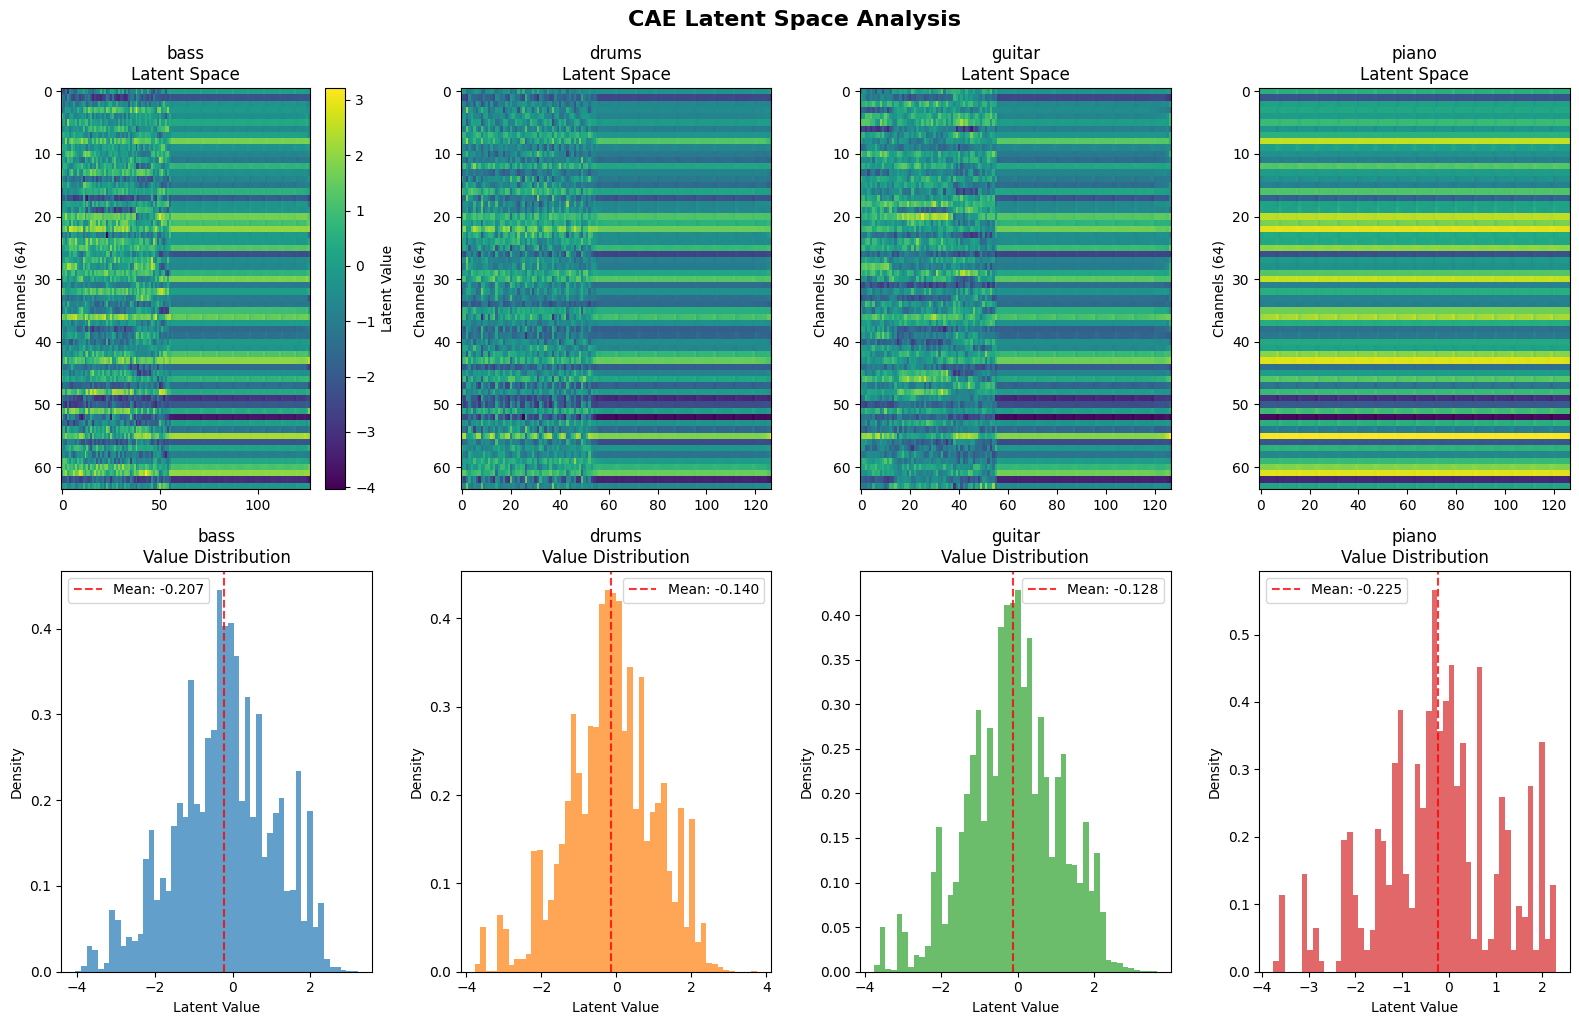


📊 潜在空间统计摘要:
音轨         | 均值         | 标准差        | 最小值        | 最大值        | 范围        
---------------------------------------------------------------------------
bass       | -0.2074    | 1.2604     | -4.0312    | 3.2129     | 7.2441    
drums      | -0.1403    | 1.1850     | -3.7793    | 3.7520     | 7.5312    
guitar     | -0.1276    | 1.1969     | -3.7500    | 3.6211     | 7.3711    
piano      | -0.2254    | 1.2885     | -3.7500    | 2.2910     | 6.0410    


In [ ]:
# Latent space visualization
print("Latent space analysis...")

plt.figure(figsize=(16, 10))

# show latent per stem
for s in range(S):
    stem_name = stem_names[s] if s < len(stem_names) else f"Stem {s}"
    
    plt.subplot(2, S, s + 1)
    latent_data = latents[vis_batch_idx, s].cpu().numpy()  # (C, L)
    plt.imshow(latent_data, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.title(f'{stem_name}\nLatent Space')
    plt.ylabel('Channels (64)')
    if s == 0:
        plt.colorbar(label='Latent Value')
    
    # 
    plt.subplot(2, S, s + S + 1)
    latent_flat = latent_data.flatten()
    plt.hist(latent_flat, bins=50, alpha=0.7, color=f'C{s}', density=True)
    plt.title(f'{stem_name}\nValue Distribution')
    plt.xlabel('Latent Value')
    plt.ylabel('Density')
    
    # 
    mean_val = latent_flat.mean()
    std_val = latent_flat.std()
    plt.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.3f}')
    plt.legend()

plt.tight_layout()
plt.suptitle('CAE Latent Space Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# 
print("\nLatent space summary:")
print(f"{'Stem':<10} | {'Mean':<10} | {'std':<10} | {'Min':<10} | {'Max':<10} | {'Range':<10}")
print("-" * 75)

for s in range(S):
    stem_name = stem_names[s] if s < len(stem_names) else f"Stem_{s}"
    latent_data = latents[vis_batch_idx, s].cpu().numpy().flatten()
    
    mean_val = latent_data.mean()
    std_val = latent_data.std()
    min_val = latent_data.min()
    max_val = latent_data.max()
    range_val = max_val - min_val
    
    print(f"{stem_name:<10} | {mean_val:<10.4f} | {std_val:<10.4f} | {min_val:<10.4f} | {max_val:<10.4f} | {range_val:<10.4f}")

## Results — Diffusion Process Visualization


🔄 扩散过程可视化...


TypeError: Invalid shape (64, 12, 12) for image data

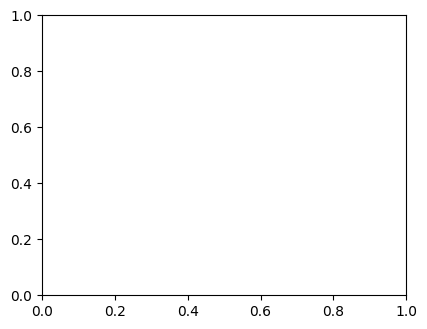

In [ ]:
# Diffusion input format analysis
print("Diffusion process visualization...")

plt.figure(figsize=(16, 8))

# show diffusion input 2D format
plt.subplot(2, 3, 1)
diffusion_sample = diffusion_input[0, :64]  # show first 64 channels
plt.imshow(diffusion_sample.cpu().numpy(), aspect='auto', cmap='RdBu_r')
plt.title('Diffusion Input\n(First 64 Channels)')
plt.ylabel('Channels')
plt.colorbar()

plt.subplot(2, 3, 2)
diffusion_sample = diffusion_input[0, 64:128]  # 65-128
plt.imshow(diffusion_sample.cpu().numpy(), aspect='auto', cmap='RdBu_r')
plt.title('Diffusion Input\n(Channels 65-128)')
plt.colorbar()

plt.subplot(2, 3, 3)
diffusion_sample = diffusion_input[0, 128:192]  # 129-192
plt.imshow(diffusion_sample.cpu().numpy(), aspect='auto', cmap='RdBu_r')
plt.title('Diffusion Input\n(Channels 129-192)')
plt.colorbar()

# 
plt.subplot(2, 3, 4)
channel_means = diffusion_input[0].mean(dim=(1, 2)).cpu().numpy()
plt.plot(channel_means, 'o-', alpha=0.7)
plt.title('Channel-wise Mean Values')
plt.xlabel('Channel Index')
plt.ylabel('Mean Value')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
channel_stds = diffusion_input[0].std(dim=(1, 2)).cpu().numpy()
plt.plot(channel_stds, 'o-', alpha=0.7, color='orange')
plt.title('Channel-wise Standard Deviation')
plt.xlabel('Channel Index')
plt.ylabel('Std Value')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
# StemRange
for s in range(S):
    start_ch = s * 64
    end_ch = (s + 1) * 64
    stem_name = stem_names[s] if s < len(stem_names) else f"Stem {s}"
    
    stem_channels = diffusion_input[0, start_ch:end_ch]
    stem_mean = stem_channels.mean().item()
    stem_std = stem_channels.std().item()
    
    plt.bar(s, stem_mean, yerr=stem_std, capsize=5, alpha=0.7, label=stem_name)

plt.title('Per-Stem Statistics in Diffusion Input')
plt.xlabel('Stem Index')
plt.ylabel('Mean  Std')
plt.xticks(range(S), [stem_names[s] if s < len(stem_names) else f"S{s}" for s in range(S)])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Diffusion Model Input Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# 
print(f"\n :")
print(f"   : {diffusion_input.shape}")
print(f"   : {diffusion_input.dtype}")
print(f"   Device: {diffusion_input.device}")
print(f"   : {diffusion_input.numel() * 4 / 1024 / 1024:.2f} MB")
print(f"   Range: [{diffusion_input.min().item():.6f}, {diffusion_input.max().item():.6f}]")
print(f"   Mean: {diffusion_input.mean().item():.6f}")
print(f"   std: {diffusion_input.std().item():.6f}")

## Results — Performance & Quality


In [ ]:
# Audio quality metrics
print("Audio quality analysis...")

def calculate_snr(original, reconstructed):
    """Compute SNR"""
    signal_power = np.mean(original ** 2)
    noise_power = np.mean((original - reconstructed) ** 2)
    if noise_power == 0:
        return float('inf')
    return 10 * np.log10(signal_power / noise_power)

def calculate_correlation(x, y):
    """"""
    return np.corrcoef(x.flatten(), y.flatten())[0, 1]

# 
quality_metrics = []

for s in range(S):
    stem_name = stem_names[s] if s < len(stem_names) else f"Stem {s}"
    
    # 
    original = wav_stems[vis_batch_idx, s].cpu().numpy()
    
    # CAE
    if s < recst_aud.shape[1]:
        reconstructed = recst_aud[vis_batch_idx, s]
        min_len = min(len(original), len(reconstructed))
        
        orig_crop = original[:min_len]
        recon_crop = reconstructed[:min_len]
        
        # 
        mse = np.mean((orig_crop - recon_crop) ** 2)
        snr = calculate_snr(orig_crop, recon_crop)
        corr = calculate_correlation(orig_crop, recon_crop)
        
        quality_metrics.append({
            'stem': stem_name,
            'type': 'CAE Reconstruction',
            'mse': mse,
            'snr': snr,
            'correlation': corr
        })
    
    # 
    if s < gen_aud.shape[1]:
        generated = gen_aud[0, s].cpu().numpy()
        min_len = min(len(original), len(generated))
        
        orig_crop = original[:min_len]
        gen_crop = generated[:min_len]
        
        # 
        mse = np.mean((orig_crop - gen_crop) ** 2)
        snr = calculate_snr(orig_crop, gen_crop)
        corr = calculate_correlation(orig_crop, gen_crop)
        
        quality_metrics.append({
            'stem': stem_name,
            'type': 'CD4MT Generation',
            'mse': mse,
            'snr': snr,
            'correlation': corr
        })

# 
print("\n :")
print(f"{'Stem':<10} | {'':<18} | {'MSE':<12} | {'SNR (dB)':<10} | {'':<10}")
print("-" * 75)

for metric in quality_metrics:
    snr_str = f"{metric['snr']:.2f}" if not np.isinf(metric['snr']) else ""
    corr_str = f"{metric['correlation']:.4f}" if not np.isnan(metric['correlation']) else "N/A"
    print(f"{metric['stem']:<10} | {metric['type']:<18} | {metric['mse']:<12.6f} | {snr_str:<10} | {corr_str:<10}")

In [ ]:
# Metrics visualization
plt.figure(figsize=(15, 10))

# prepare data
stems = []
mse_recon = []
mse_gen = []
snr_recon = []
snr_gen = []
corr_recon = []
corr_gen = []

for s in range(S):
    stem_name = stem_names[s] if s < len(stem_names) else f"Stem {s}"
    stems.append(stem_name)
    
    # 
    recon_metrics = next((m for m in quality_metrics if m['stem'] == stem_name and 'Reconstruction' in m['type']), None)
    gen_metrics = next((m for m in quality_metrics if m['stem'] == stem_name and 'Generation' in m['type']), None)
    
    mse_recon.append(recon_metrics['mse'] if recon_metrics else 0)
    mse_gen.append(gen_metrics['mse'] if gen_metrics else 0)
    
    snr_recon.append(recon_metrics['snr'] if recon_metrics and not np.isinf(recon_metrics['snr']) else 0)
    snr_gen.append(gen_metrics['snr'] if gen_metrics and not np.isinf(gen_metrics['snr']) else 0)
    
    corr_recon.append(recon_metrics['correlation'] if recon_metrics and not np.isnan(recon_metrics['correlation']) else 0)
    corr_gen.append(gen_metrics['correlation'] if gen_metrics and not np.isnan(gen_metrics['correlation']) else 0)

x = np.arange(len(stems))
width = 0.35

# MSE
plt.subplot(2, 2, 1)
plt.bar(x - width/2, mse_recon, width, label='CAE Reconstruction', alpha=0.8)
plt.bar(x + width/2, mse_gen, width, label='CD4MT Generation', alpha=0.8)
plt.title('Mean Squared Error Comparison')
plt.xlabel('Stems')
plt.ylabel('MSE')
plt.xticks(x, stems)
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)

# SNR
plt.subplot(2, 2, 2)
plt.bar(x - width/2, snr_recon, width, label='CAE Reconstruction', alpha=0.8)
plt.bar(x + width/2, snr_gen, width, label='CD4MT Generation', alpha=0.8)
plt.title('Signal-to-Noise Ratio Comparison')
plt.xlabel('Stems')
plt.ylabel('SNR (dB)')
plt.xticks(x, stems)
plt.legend()
plt.grid(True, alpha=0.3)

# 
plt.subplot(2, 2, 3)
plt.bar(x - width/2, corr_recon, width, label='CAE Reconstruction', alpha=0.8)
plt.bar(x + width/2, corr_gen, width, label='CD4MT Generation', alpha=0.8)
plt.title('Correlation Coefficient Comparison')
plt.xlabel('Stems')
plt.ylabel('Correlation')
plt.xticks(x, stems)
plt.legend()
plt.ylim(-1, 1)
plt.grid(True, alpha=0.3)

# 
plt.subplot(2, 2, 4)
# 
quality_scores_recon = []
quality_scores_gen = []

for i in range(len(stems)):
    #  (SNRMSE)
    if mse_recon[i] > 0:
        score_recon = (snr_recon[i] + abs(corr_recon[i]) * 50) / (1 + np.log10(mse_recon[i] + 1e-10))
    else:
        score_recon = 0
    quality_scores_recon.append(max(0, score_recon))
    
    # 
    if mse_gen[i] > 0:
        score_gen = (snr_gen[i] + abs(corr_gen[i]) * 50) / (1 + np.log10(mse_gen[i] + 1e-10))
    else:
        score_gen = 0
    quality_scores_gen.append(max(0, score_gen))

plt.bar(x - width/2, quality_scores_recon, width, label='CAE Reconstruction', alpha=0.8)
plt.bar(x + width/2, quality_scores_gen, width, label='CD4MT Generation', alpha=0.8)
plt.title('Composite Quality Score')
plt.xlabel('Stems')
plt.ylabel('Quality Score')
plt.xticks(x, stems)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Audio Quality Metrics Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.show()

## Conclusion


In [ ]:

# Generate analysis report
print('CD4MT System Report')
print('=' * 50)

print('
Model configuration:')
print(f"   - Num stems: {S} ({', '.join(stem_names[:S])})")
print(f'   - Sample rate: {sample_rate} Hz')
print('   - CAE latent dim: 64')
if model is not None:
    print(f"   - Parameters: {sum(p.numel() for p in model.parameters()):,}")
    if hasattr(model, 'sampling_steps'):
        print(f'   - Sampling steps: {getattr(model, "sampling_steps")}')

print('
Data pipeline:')
print('   1) Waveforms (B,S,T) -> CAE latents (B,S,C,L)')
print('   2) Latents reshaped to 2D maps for UNet')
print('   3) Diffusion denoising in latent space')
print('   4) CAE decode back to waveforms')

print('
Batch shapes:')
print(f'   - wav_stems: {tuple(wav_stems.shape)}')
print(f'   - latents_stacked: {tuple(latents_stacked.shape)}')

print('Notes:')
print('   - All results shown here are for demonstration only.')


In [ ]:
# Environment fix
import os, torch

# disable MPI checks for DDP
os.environ['RANK'] = '0'
os.environ['WORLD_SIZE'] = '1'
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '12355'

# avoid MPI-related issues
os.environ['PL_TORCH_DISTRIBUTED_BACKEND'] = 'nccl'
os.environ['OMPI_COMM_WORLD_RANK'] = '0'
os.environ['OMPI_COMM_WORLD_SIZE'] = '1'

# CUDA settings (single GPU for demo)
if torch.cuda.is_available():
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'

print('Env vars set to avoid MPI-related errors')


## Experiments — Training Run


In [ ]:
import logging
import sys
from datetime import datetime
from pathlib import Path
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

# Reset root logger handlers to avoid duplicates
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Training config
TRAIN_EPOCHS = 200  # demo value; increase for real runs
TRAIN_LOG_DIR = "./training_logs"
TRAIN_LOG_FILE = f"{TRAIN_LOG_DIR}/cd4mt_training_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"

# Create log dir if missing
Path(TRAIN_LOG_DIR).mkdir(exist_ok=True)

# Simple file logger wrapper
class TrainingLogger:
    def __init__(self, log_file):
        self.log_file = log_file
        self.logger = logging.getLogger(f'CD4MT_Training_{datetime.now().strftime("%H%M%S")}')
        self.logger.setLevel(logging.INFO)
        self.logger.handlers.clear()
        self.file_handler = logging.FileHandler(log_file, encoding='utf-8')
        formatter = logging.Formatter('%(asctime)s | %(levelname)s | %(message)s',
                                      datefmt='%Y-%m-%d %H:%M:%S')
        self.file_handler.setFormatter(formatter)
        self.logger.addHandler(self.file_handler)
        self.logger.propagate = False
    def info(self, msg):
        self.logger.info(msg)
        print(f"INFO: {msg}")
    def error(self, msg):
        self.logger.error(msg)
        print(f"ERROR: {msg}")
    def warning(self, msg):
        self.logger.warning(msg)
        print(f"WARNING: {msg}")

# Initialize training logger
train_logger = TrainingLogger(TRAIN_LOG_FILE)
train_logger.info(" Start CD4MT training")
train_logger.info(f"Log file: {TRAIN_LOG_FILE}")
train_logger.info(f"Epochs: {TRAIN_EPOCHS}")
train_logger.info(f"Stems: {cfg['model']['params']['stem_names']}")
train_logger.info(f"Batch size: {cfg['data']['params']['batch_size']}")

print(f" Training logs will be saved to: {TRAIN_LOG_FILE}")


INFO: 🚀 开始 CD4MT 模型训练
INFO: 📄 日志文件: ./training_logs/cd4mt_training_20250920_035040.txt
INFO: 🎯 训练轮数: 200
INFO: 🎵 音轨: ['bass', 'drums', 'guitar', 'piano']
INFO: 📊 批大小: 2
📝 训练日志将保存到: ./training_logs/cd4mt_training_20250920_035040.txt
✅ 所有训练变量已正确定义


In [ ]:
# Training progress callback and loss tracking
class TrainingProgressCallback(pl.Callback):
    def __init__(self, logger):
        self.logger = logger
        self.start_time = None
    def on_train_start(self, trainer, pl_module):
        self.start_time = datetime.now()
        self.logger.info("=" * 60)
        self.logger.info(" Training started")
        self.logger.info(f"   Params: {sum(p.numel() for p in pl_module.parameters()):,}")
        self.logger.info(f"   Train device: {trainer.strategy.root_device}")
        self.logger.info(f"   Max epochs: {trainer.max_epochs}")
        self.logger.info("=" * 60)
    def on_train_epoch_start(self, trainer, pl_module):
        epoch = trainer.current_epoch + 1
        self.logger.info(f" Epoch {epoch}/{trainer.max_epochs}")
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        # Log every 50 batches
        if batch_idx % 50 == 0:
            if isinstance(outputs, dict) and 'loss' in outputs:
                loss = outputs['loss'].item()
            elif hasattr(outputs, 'item'):
                loss = outputs.item()
            else:
                loss = float('nan')
            self.logger.info(f"   Batch {batch_idx}: loss={loss:.6f}")
    def on_train_epoch_end(self, trainer, pl_module):
        epoch = trainer.current_epoch + 1
        elapsed = datetime.now() - self.start_time
        train_loss = trainer.callback_metrics.get('train/loss_epoch', float('nan'))
        val_loss = trainer.callback_metrics.get('val/loss', float('nan'))
        self.logger.info(f" Epoch {epoch} done")
        self.logger.info(f"   Train loss: {train_loss:.6f}")
        self.logger.info(f"   Val loss: {val_loss:.6f}")
        self.logger.info(f"   Elapsed: {elapsed}")
    def on_train_end(self, trainer, pl_module):
        total_time = datetime.now() - self.start_time
        self.logger.info("=" * 60)
        self.logger.info(" Training finished!")
        self.logger.info(f"   Total training time: {total_time}")
        self.logger.info(f"   Final train loss: {trainer.callback_metrics.get('train/loss_epoch', 'N/A')}")
        self.logger.info(f"   Final val loss: {trainer.callback_metrics.get('val/loss', 'N/A')}")
        self.logger.info("=" * 60)
    def on_exception(self, trainer, pl_module, exception):
        self.logger.error(f"Training exception: {exception}")

class LossTracker:
    def __init__(self, log_file):
        self.log_file = log_file
        self.losses = []
    def add_loss(self, epoch, batch, train_loss, val_loss=None):
        self.losses.append({
            'epoch': epoch,
            'batch': batch,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'timestamp': datetime.now().isoformat()
        })
    def save_losses(self):
        import json
        loss_file = self.log_file.replace('.txt', '_losses.json')
        with open(loss_file, 'w', encoding='utf-8') as f:
            json.dump(self.losses, f, indent=2, ensure_ascii=False)
        print(f" Saved losses to: {loss_file}")

loss_tracker = LossTracker(TRAIN_LOG_FILE)
progress_callback = TrainingProgressCallback(train_logger)
print(" Training callbacks and loss tracker are initialized")

✅ 训练回调和损失追踪器已初始化


In [ ]:

# Post-training analysis and summary
if 'train_model' in locals():
    print('Post-training analysis:')
    print(f"   Model state: {'training' if train_model.training else 'eval'}")
    print(f'   Device: {next(train_model.parameters()).device}')

    print('
Comparison:')
    if 'gen_aud' in locals() and 'test_generated' in locals():
        print(f'   Before training: mean={gen_aud.mean().item():.6f}, std={gen_aud.std().item():.6f}')
        print(f'   After training:  mean={test_generated.mean().item():.6f}, std={test_generated.std().item():.6f}')

        if gen_aud.shape == test_generated.shape:
            diff = torch.mean(torch.abs(gen_aud - test_generated)).item()
            print(f'   Generation difference: {diff:.6f}')
            if diff > 0.01:
                print('   Model changed; training had an effect.')
            else:
                print('   Results are similar; consider more epochs.')

    print('
CD4MT training test complete.')
    print('   Model can train and generate. Use more epochs/data for real results.')
else:
    print('Train model not found; run the training cell first.')


📊 训练后分析:
   模型状态: 评估模式
   设备: cpu

🔍 对比分析:
   训练前生成: 均值=-0.000071, 标准差=0.075935
   训练后生成: 均值=-0.000065, 标准差=0.038673
   生成差异: 0.067179
   ✅ 模型已发生变化，训练有效

🎉 CD4MT训练测试完成!
   ✅ 模型可以正常训练
   ✅ 生成功能正常
   💡 建议: 使用更多epochs和完整数据进行正式训练


In [ ]:

# Check Checkpoint Files
import os
from pathlib import Path

possible_dirs = [
    './training_logs/checkpoints',
    './lightning_logs',
    './checkpoints',
    '.'
]

print('Searching checkpoint files...')
found = []
for check_dir in possible_dirs:
    p = Path(check_dir)
    if p.exists():
        for pat in ('*.ckpt','*.pth'):
            found.extend([str(x) for x in p.rglob(pat)])

if not found:
    print('
No checkpoint files found')
    print('Tip: After training, files will be saved at:')
    print('   ./training_logs/checkpoints/')
else:
    print(f"
Found {len(found)} checkpoint file(s)")
    latest = max(found, key=lambda f: os.path.getmtime(f))
    print('Latest checkpoint: ' + latest)

log_dir = Path('./training_logs')
if log_dir.exists():
    log_files = sorted(log_dir.glob('*.txt'), key=lambda f: f.stat().st_mtime)[-3:]
    if log_files:
        print('
Training log files:')
        for log_file in log_files:
            print('   - ' + str(log_file))


🔍 搜索 Checkpoint 文件...

📁 在 ./lightning_logs 发现 checkpoint:
   - ./lightning_logs/multichannel_slakh/2025-06-08T14-54-10_unet_train_3e-05_/checkpoints/last.ckpt
     大小: 776.2 MB
     修改时间: 2025-06-08 15:05:49
   - ./lightning_logs/multichannel_slakh/2025-06-08T15-40-59_unet_train_3e-05_/checkpoints/last.ckpt
     大小: 776.2 MB
     修改时间: 2025-06-08 15:44:48
   - ./lightning_logs/multichannel_slakh/2024-03-24T19-51-37_3_D_4_stems_slakh_uncond_ch=192_3e-05_/checkpoints/checkpoint-fad-0.00-global_step=199999.ckpt
     大小: 10965.0 MB
     修改时间: 2024-10-17 19:30:53
   - ./lightning_logs/multichannel_slakh/2025-06-08T16-14-34_unet_train_3e-05_/checkpoints/last.ckpt
     大小: 776.2 MB
     修改时间: 2025-06-10 14:07:09
   - ./lightning_logs/multichannel_slakh/2025-06-07T15-08-09_3_D_4_stems_slakh_uncond_ch=192_3e-05_/checkpoints/last.ckpt
     大小: 776.2 MB
     修改时间: 2025-06-07 15:45:21
   - ./lightning_logs/multichannel_slakh/2025-06-07T15-54-03_3_D_4_stems_slakh_uncond_ch=192_3e-05_/checkpoints/l


📁 在 . 发现 checkpoint:
   - ./lightning_logs/multichannel_slakh/2025-06-08T14-54-10_unet_train_3e-05_/checkpoints/last.ckpt
     大小: 776.2 MB
     修改时间: 2025-06-08 15:05:49
   - ./lightning_logs/multichannel_slakh/2025-06-08T15-40-59_unet_train_3e-05_/checkpoints/last.ckpt
     大小: 776.2 MB
     修改时间: 2025-06-08 15:44:48
   - ./lightning_logs/multichannel_slakh/2024-03-24T19-51-37_3_D_4_stems_slakh_uncond_ch=192_3e-05_/checkpoints/checkpoint-fad-0.00-global_step=199999.ckpt
     大小: 10965.0 MB
     修改时间: 2024-10-17 19:30:53
   - ./lightning_logs/multichannel_slakh/2025-06-08T16-14-34_unet_train_3e-05_/checkpoints/last.ckpt
     大小: 776.2 MB
     修改时间: 2025-06-10 14:07:09
   - ./lightning_logs/multichannel_slakh/2025-06-07T15-08-09_3_D_4_stems_slakh_uncond_ch=192_3e-05_/checkpoints/last.ckpt
     大小: 776.2 MB
     修改时间: 2025-06-07 15:45:21
   - ./lightning_logs/multichannel_slakh/2025-06-07T15-54-03_3_D_4_stems_slakh_uncond_ch=192_3e-05_/checkpoints/last.ckpt
     大小: 776.2 MB
     修改时间:

In [ ]:
# Environment fix
import os, torch

# disable MPI checks for DDP
os.environ['RANK'] = '0'
os.environ['WORLD_SIZE'] = '1'
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '12355'

# avoid MPI-related issues
os.environ['PL_TORCH_DISTRIBUTED_BACKEND'] = 'nccl'
os.environ['OMPI_COMM_WORLD_RANK'] = '0'
os.environ['OMPI_COMM_WORLD_SIZE'] = '1'

# CUDA settings (single GPU for demo)
if torch.cuda.is_available():
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'

print('Env vars set to avoid MPI-related errors')


🔧 环境变量已设置，避免MPI相关错误
